In [6]:
import righor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import os
os.environ["RUST_BACKTRACE"] = "1"


# load the model
igor_model = righor.load_model("human", "trb")
# alternatively, you can load a model from igor files 
# igor_model = righor.load_model_from_files(params.txt, marginals.txt, anchor_v.csv, anchor_j.csv)

In [7]:
import itertools

def rc(seq):
    """ Return the reverse-complement of a nucleotide sequences """
    dct = {"A": "T", "G": "C", "T": "A", "C": "G", "R": "Y", "Y": "R", "S": "S",
           "W": "W", "K": "M", "M": "K", "B": "V", "D": "H", "H": "D", "V": "B", "N": "N"}
    return "".join([dct[a] for a in seq][::-1])

bases = "TCAG"
codons = [a + b + c for a in bases for b in bases for c in bases]
aminoacids = 'FFLLSSSSYY**CC*WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'
to_aminoacid = dict(zip(codons, aminoacids))
to_codons = {}
for a, c in zip(aminoacids, codons):
    if a in to_codons:
        to_codons[a].append(c)
    else:
        to_codons[a] = [c]

def n_to_aa(x):
    """ Transform the sequence x to its nucleotide form """
    return "".join([to_aminoacid[x[i:i+3]] for i in range(0, len(x), 3)])


def aa_to_n(x):
    """ Return all the possible versions of the aa sequence x
    in nucleotide form """
    for s in itertools.product(*(to_codons[a] for a in x)):
        yield "".join(s)

In [8]:
igor_model.error = righor.ErrorParameters.constant_error(0.)

In [9]:
aa_sequence = "CASRRTANYGYTF"
all_n_sequences = list(aa_to_n(aa_sequence))

In [10]:
my_sequence = f"GAAGCCCAAGTGACCCAGAACCCAAGATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTCTCAGAATATGAACCATGAGTATATGTCCTGGTATCGACAAGACCCAGGGCTGGGCTTAAGGCAGATCTACTATTCAATGAATGTTGAGGTGACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAGAGAAGAGGAATTTCCCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTCGGTTCGGGGACCAGGTTAACCGTTGTAG"
result_inference = igor_model.evaluate(my_sequence)
print(result_inference.best_event.cdr3)

TGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTC


In [12]:
# test generic nucleotide
my_sequence = f"GAAGCCCAAGTGACCCAGAACCCAAGATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTCTCAGAATATGAACCATGAGTATATGTCCTGGTATCGACAAGACCCAGGGCTGGGCTTAAGGCAGATCTACTATTCAATGAATGTTGAGGTGACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAGAGAAGAGGAATTTCCCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCCGACNGACAGCTAACTATGGCTACACCTTCGGTTCGGGGACCAGGTTAACCGTTGTAG"
result_inference = igor_model.evaluate(my_sequence)
print("Generic nucleotide test: ", result_inference.likelihood)

s = 0
for a in 'ATGC':
    my_seq  = f"GAAGCCCAAGTGACCCAGAACCCAAGATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTCTCAGAATATGAACCATGAGTATATGTCCTGGTATCGACAAGACCCAGGGCTGGGCTTAAGGCAGATCTACTATTCAATGAATGTTGAGGTGACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAGAGAAGAGGAATTTCCCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCCGAC{a}GACAGCTAACTATGGCTACACCTTCGGTTCGGGGACCAGGTTAACCGTTGTAG"
    result_inference = igor_model.evaluate(my_seq)
    s += result_inference.likelihood
    print(result_inference.likelihood)
print("Comparison with sum of likelihood: ",  s)

Generic nucleotide test:  1.5009861972416256e-11
3.013067586448517e-11
8.004562058290319e-12
4.5317041202240325e-11
1.631227818844307e-11
Comparison with sum of likelihood:  9.976455731345889e-11


In [3]:
my_sequence = "TGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTC"
%env RUST_BACKTRACE=1
# evaluate the sequence
result_inference = igor_model.evaluate((righor.Dna(my_sequence), igor_model.v_segments, igor_model.j_segments))
result_inference.best_event

env: RUST_BACKTRACE=1


In [4]:
result_inference.best_event.reconstructed_sequence

GAAGCCCAAGTGACCCAGAACCCAAGATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTCTCAGAATATGAACCATGAGTATATGTCCTGGTATCGACAAGACCCAGGGCTGGGCTTAAGGCAGATCTACTATTCAATGAATGTTGAGGTGACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAGAGAAGAGGAATTTCCCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTCGGTTCGGGGACCAGGTTAACCGTTGTAG

In [5]:
result_inference.best_event.full_sequence

GAAGCCCAAGTGACCCAGAACCCAAGATACCTCATCACAGTGACTGGAAAGAAGTTAACAGTGACTTGTTCTCAGAATATGAACCATGAGTATATGTCCTGGTATCGACAAGACCCAGGGCTGGGCTTAAGGCAGATCTACTATTCAATGAATGTTGAGGTGACTGATAAGGGAGATGTTCCTGAAGGGTACAAAGTCTCTCGAAAAGAGAAGAGGAATTTCCCCCTGATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTCGGTTCGGGGACCAGGTTAACCGTTGTAG

In [ ]:
err_ps = (np.cos(10*np.linspace(0, 1, 100))**2)
err_ps /= err_ps.sum()
error_model = righor.ErrorParameters.uniform_error(err_ps, 
                                                   np.linspace(0, 1, 101))
#error_model = righor.ErrorParameters.constant_error(0.2)
igor_model.error = error_model

In [18]:
## Generate sequences

# Create a generator object
generator = igor_model.generator(seed=42) # or igor_model.generator() to run it without a seed

# Generate 10'000 functional sequences (not out-of-frame, no stop codons, right boundaries)
for _ in tqdm(range(10000)):
    # generate_without_errors ignore Igor error model, use "generate" if this is needed
    sequence = generator.generate_without_errors(functional=True)
    if "IGH" in sequence.cdr3_aa:
        print("TRB CDR3 containing \"IGH\":", sequence.cdr3_aa)

print()

# Generate one sequence with a particular V/J genes family 
V_genes = righor.genes_matching("TRBV2", igor_model) # return all the V genes that match TRBV5
J_genes = righor.genes_matching("TRBJ", igor_model) # all the J genes
generator = igor_model.generator(seed=40, available_v=V_genes, available_j=J_genes) 
generation_result = generator.generate(functional=True)
print("Result:")
print(generation_result)
print("Explicit recombination event:")
print(generation_result.recombination_event)

  0%|          | 0/10000 [00:00<?, ?it/s]

TRB CDR3 containing "IGH": CASSMYLRDIGHTQYF
TRB CDR3 containing "IGH": CASSEKGGGQIGHSYEQYF

Result:
GenerationResult(
CDR3 (nucletides): TGTGCCAGCCGACGGACAGCTAACTATGGCTACACCTTC,
CDR3 (amino-acids): CASRRTANYGYTF,
Full sequence (nucleotides): GAACCTGAAGTCACCCAGACTCCCAGCCAT...,
V gene: TRBV2*01,
J gene: TRBJ1-2*01)
		 
Explicit recombination event:
StaticEvent(
nb. del. on V3: 12,
nb. del. on D5: 6,
nb. del. on D3: 9,
nb. del. on J5: 4,
V-D insertions: CGACG,
D-J insertions: ,
errors: None)


In [10]:
## Evaluate a given sequence
%env RUST_BACKTRACE=1
my_sequence = "ACCCTCCAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACAGGGACGTCACTGAAGCTTTCTTTGGACAAGGCACC"

# evaluate the sequence
result_inference = igor_model.evaluate(my_sequence)

# Most likely scenario
best_event = result_inference.best_event

print(f"Probability that this specific event chain created the sequence: {best_event.likelihood / result_inference.likelihood:.2f}.")
print(f"Reconstructed sequence (without errors):", best_event.reconstructed_sequence)
print(f"Pgen: {result_inference.pgen:.1e}")

env: RUST_BACKTRACE=1
Probability that this specific event chain created the sequence: 0.00.
Reconstructed sequence (without errors): GAAGCTGACATCTACCAGACCCCAAGATACCTTGTTATAGGGACAGGAAAGAAGATCACTCTGGAATGTTCTCAAACCATGGGCCATGACAAAATGTACTGGTATCAACAAGATCCAGGAATGGAACTACACCTCATCCACTATTCCTATGGAGTTAATTCCACAGAGAAGGGAGATCTTTCCTCTGAGTCAACAGTCTCCAGAATAAGGACGGAGCATTTTCCCCTGACCCTGGAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACCGGGACTAGCGGGAGGCTTTCTTTGGACAAGGCACCAGACTCACAGTTGTAG
Pgen: 3.9e-12


In [11]:
# Inference of a model 
# use a very small number of sequences to keep short (still takes a few minutes)

# here we just generate the sequences needed
generator = igor_model.generator()
example_seq = generator.generate(False)
sequences = [generator.generate(False).full_seq for _ in range(100)]

# define parameters for the alignment and the inference (also possible for the evaluation)
align_params = righor.AlignmentParameters()
align_params.left_v_cutoff = 70
infer_params = righor.InferenceParameters()

# generate an uniform model as a starting point 
# (it's generally much faster to use an already inferred model as the starting point)
model = igor_model.copy().uniform()

# multiple round of expectation-maximization to infer the model
models = {}
model = igor_model.uniform()
models[0] = model
for ii in tqdm(range(35)):
    models[ii+1] = models[ii].copy()
    models[ii+1].infer(sequences,
                       align_params,
                       infer_params)

  0%|          | 0/35 [00:00<?, ?it/s]

In [14]:
models[10].error

Uniform Error model [each sequence can have a ≠ number of mutations, distributed uniformly along the sequence].
Average error rate= 0.00006600000000000002

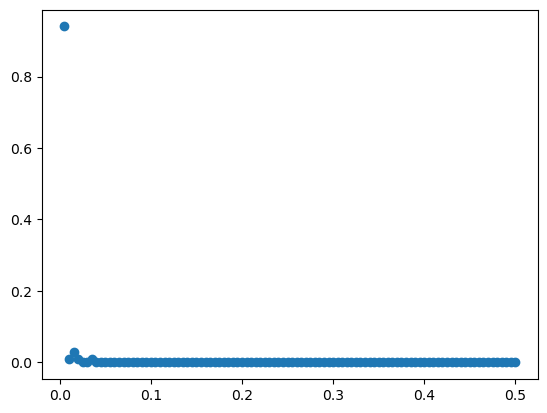

In [23]:
bins, probas = models[6].error.probability_distribution
bins = np.array(bins)
plt.scatter((bins[:1] + bins[1:])/2., probas)

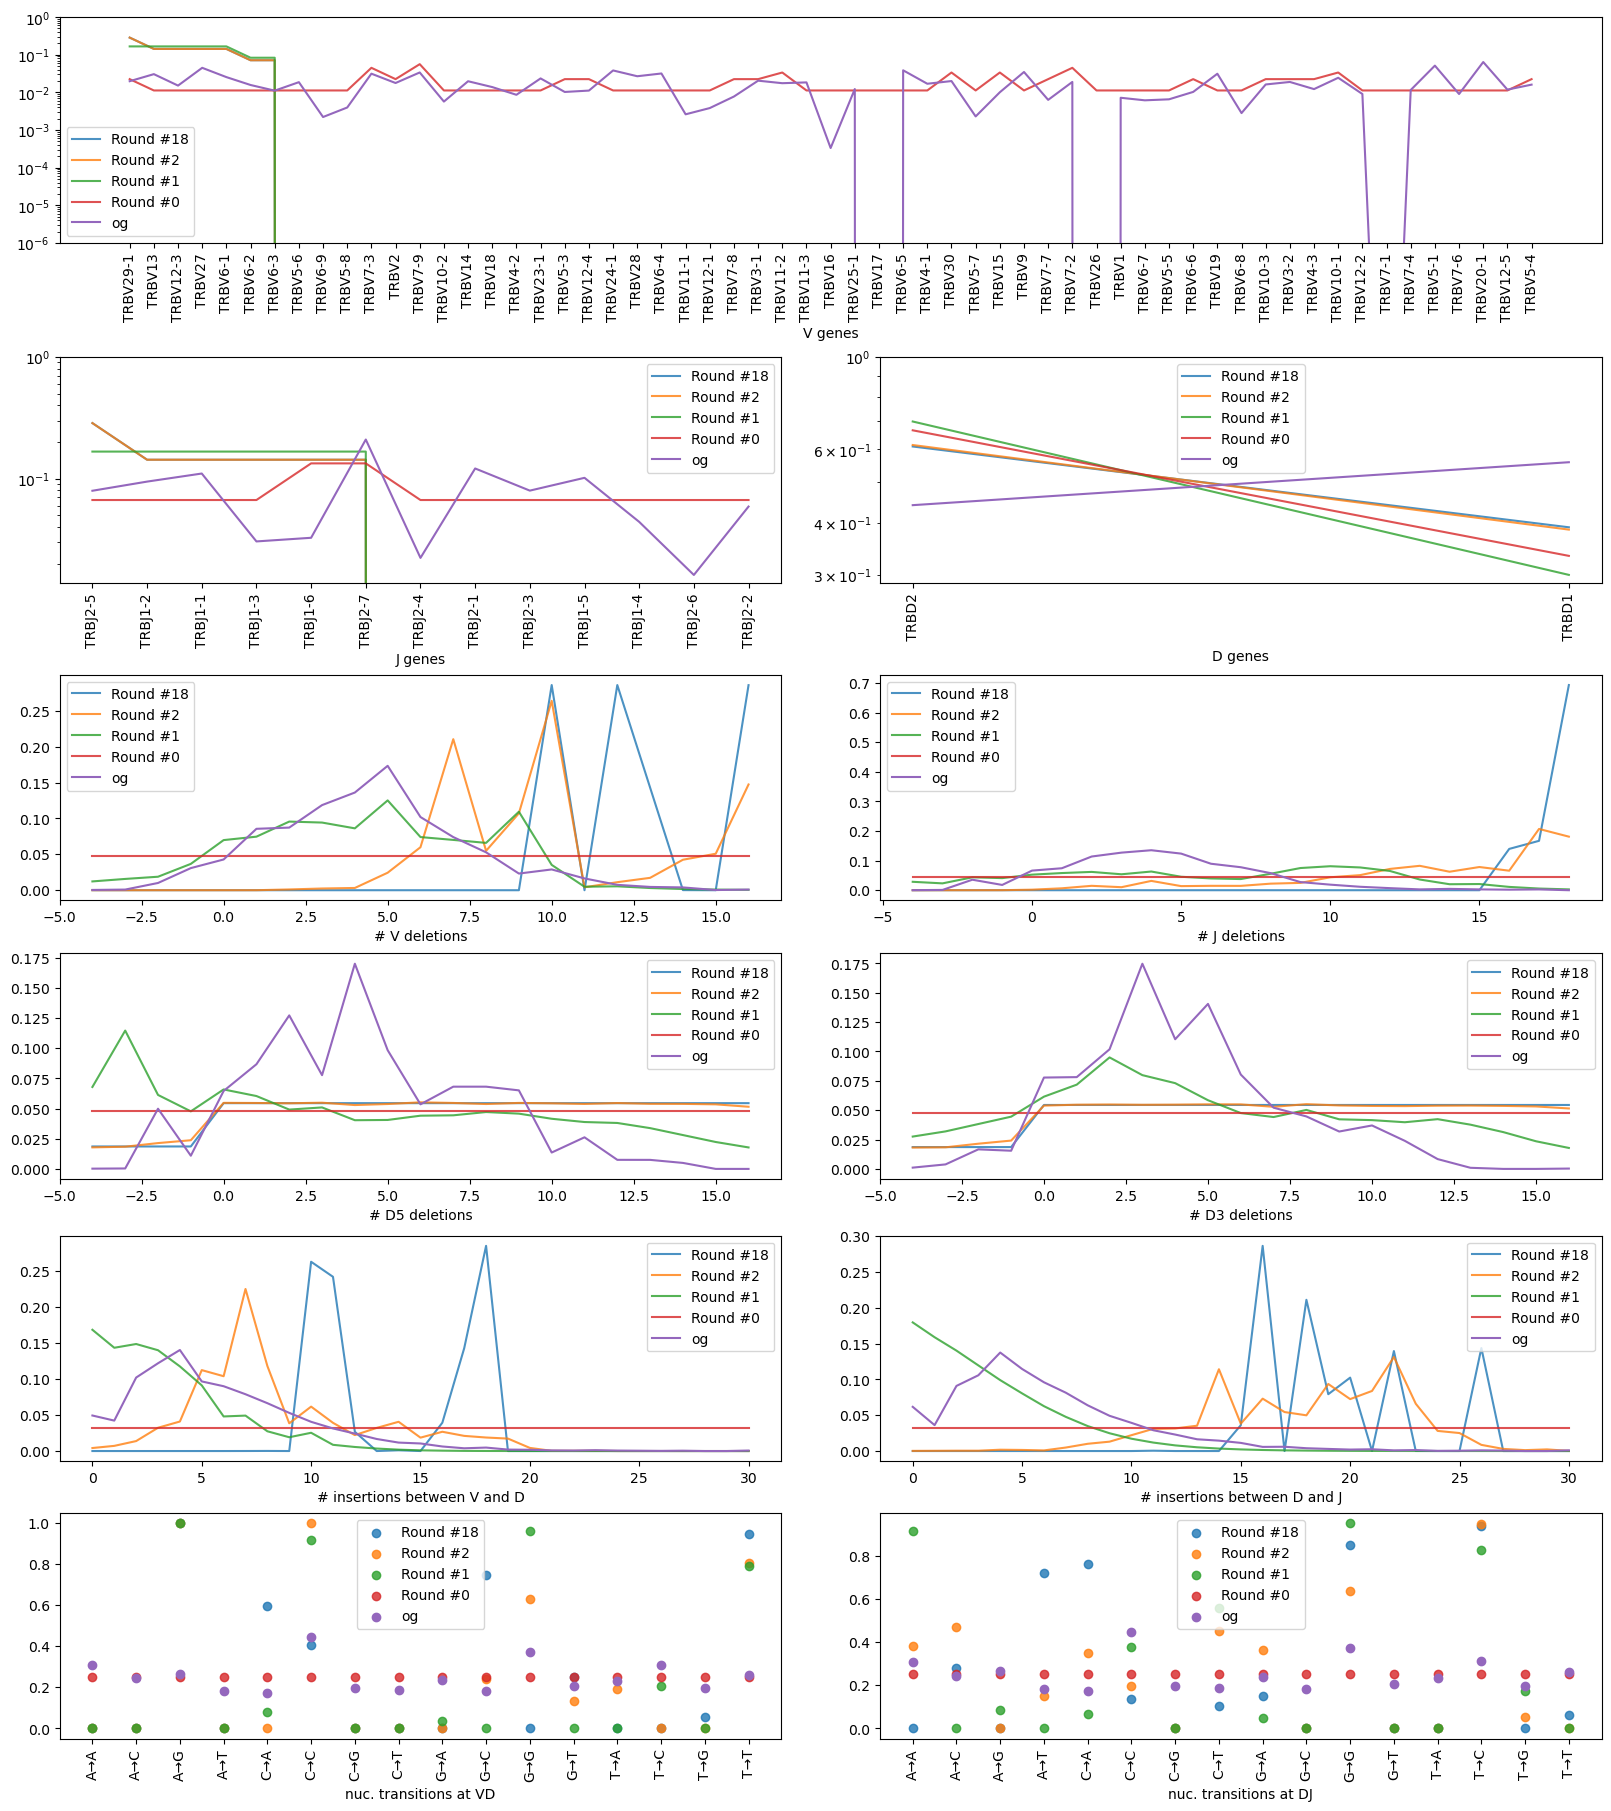

In [15]:
# visualisation of the results
fig = righor.plot_vdj(*[models[ii] for ii in [10, 2, 1, 0]] + [igor_model],
            plots_kws=[{'label':f'Round #{ii}', 'alpha':0.8} for ii in [18,2, 1, 0]] + [{'label':f'og'}] )


In [ ]:
righor.vdj.Model.load_model_from_files

In [ ]:
bins, probas = igor_model.error.probability_distribution
plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)


bins, probas = model.error.probability_distribution
plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)


for ii in range(35):
    bins, probas = models[ii].error.probability_distribution
    plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)

In [ ]:
# save the model in the Igor format
# will return an error if the directory already exists
models[10].save_model('test_save')
# load the model
igor_model = righor.vdj.Model.load_model_from_files('test_save/model_params.txt',
                                          'test_save/model_marginals.txt',
                                          'test_save/V_gene_CDR3_anchors.csv',
                                          'test_save/J_gene_CDR3_anchors.csv')

# save the model in json format (one file)
models[10].save_json('test_save.json')
# load the model in json
igor_model = righor.vdj.Model.load_json('test_save.json')